# Supplement 2: Total Alkalinity Calculation from One-Point Titration

High-Precision characterisation of indicator dyes by Spectral Fitting: Application to Swawater pH and Alkalinity measurements. Branson & Ellwood. *In Review.*

## Contents
1. [Total Alkalinity of Seawater](#1_TA)
    1. [One Point Titration](#1A_onepoint)
    2. [TA Measurement Landscape](#1B_TAland)
2. [Minimising uncertainties in TA measurements¶](#2_TAun)
    1. [Sources of Uncertainty in a TA Measurement](#2A_TAunc)
    2. [What is the optimal titration end-point pH for a TA measurement? ](#2B_endpH)
3. [Is Bubbling Necessary?](#3_bubbles)

### Figures
4. [Sources of Uncertainty in a TA Measurement](#fig4)
5. [Uncertainty in a TA Measurement](#fig5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cbsyst as cb
from uncertainties import unumpy as unp

from carbspec.alkalinity import TA_from_pH
from carbspec.alkalinity import uncertainty as unTA
from carbspec import dye

# L&O plot specs
# https://aslopubs.onlinelibrary.wiley.com/hub/journal/15415856/about/author-guidelines#7
cw = 4  # column width = 3.5 inches
figpath = './figs/'

<a id="1_TA"></a>
## 1. Total Alkalinity of Seawater

Total alkalinity is the molar concentration of $H^+$ required to titrate seawater to the equivalence point of the reaction:

$$
H_2CO_3 \leftrightarrow H^+ + HCO_3^-
$$

This titration involves numerous acid-base reactions in seawater, and is defined as:

$$
TA = [HCO_3^-] + 2[CO_3^{2-}] + [OH^-] + [B(OH)_4^-] + [HPO_4^{2-}] + 2[PO_4^{3-}] + [SiO(OH)_3^-] - [H^+]_F - [HSO_4^-] - [HF] - [H_3PO_4]
$$

Inversely, the total (analytical) hydrogen ion concentration of seawater ($C_H$) is given by:

$$
C_H = [H^+]_F + [HSO_4^-] + [HF] + [H_3PO_4] - [HCO_3^-] - 2[CO_3^{2-}] - [OH^-] - [B(OH)_4^-] - [HPO_4^{2-}] - 2[PO_4^{3-}] - [SiO(OH)_3^-] 
$$

Note that the *analytical* hydrogen ion concentration is the total concentration of hydrogen ions that that would be measured by titration, accounting so includes buffering effects. It is distinct from $[H^+]^{Total}$, which is the combination of $[H^+]_F$ and $[HSO_4^-]$ used as the basis of the Total pH scale.

The pKa values for the relevant acid/base reactions are (S=35, T=25):
 - **pK<sub>1</sub>**: 5.847
 - **pK<sub>2</sub>**: 8.965
 - **pK<sub>S</sub>**: 0.998
 - **pK<sub>B</sub>**: 8.597
 - **pK<sub>W</sub>**: 13.220
 - **pK<sub>P1</sub>**: 1.615
 - **pK<sub>P2</sub>**: 5.964
 - **pK<sub>P3</sub>**: 8.792
 - **pK<sub>F</sub>**: 2.626
 - **pK<sub>Si</sub>**: 9.386


<a id="1A_onepoint"></a>
### 1A. One-Point Titration

The analytical hydrogen ion concentration of seawater will increase by titration of a strong acid (e.g. HCl), but be buffered by the TA of seawater. Therefore, the $C_H$ resulting from an open-cell (air equilibrated) mixture of seawater and a strong acid can be expressed as:

$$
C_H = \frac{m C - m_0 TA}{m + m_0}
$$

where $m_0$ is the mass of seawater, m is the mass of acid added and C is the concentration of the acid.

The end-pH of acid/seawater titrations is generally between 3-4.5. As evident in the pK values for the acid-base reactions involved in TA, a more useful definition of TA (or $C_H$ in this pH range is:

$$
C_H = [H^+]_F + [HSO_4^-] + [HF]
$$

Therefore,

$$
\frac{m C - m_0 TA}{m + m_0} = [H^+]_F + [HSO_4^-] + [HF]
$$

which can be re-arranged to yield:

$$
TA = \frac{m C}{m_0} - \frac{m + m_0}{m_0} ([H^+]_F + [HSO_4^-] + [HF])
$$

Given knowledge of seawater temperature and salinity, the $[H^+]_F$, $[HSO_4^-]$ and $[HF]$ can be determined, following:

$$
\begin{align}
[H^+]_F &= \frac{[H^+]_T}{1 + \frac{S_T}{K_{S}}} \\
[HSO_4^-] &= \frac{S_T}{1 + \frac{K_{S}}{[H^+]_F}} = \frac{S_T}{1 + \frac{K_{S} (1 + \frac{S_T}{K_{S}})}{[H^+]_T}}\\
[HF] &= \frac{F_T}{1 + \frac{K_F}{[H^+]_T}}
\end{align}
$$

Where $X_T$ is the total concentration of S or F in seawater determined from salinity, and K_X is the stoichiometric equilibrium constant for the known temperature and salinity, determined using standard methods (e.g. Dickson, Sabine and Christian, 2007).

Thus, TA can be determined from a one-point titration where all of $m$, $m_0$, $C$, $[H^+]_T$, salinity and temperature are known:

$$
TA = \frac{m C}{m_0} - \frac{m + m_0}{m_0} \left( \frac{[H^+]_T}{1 + \frac{S_T}{K_{S}}} + \frac{S_T}{1 + K_{S} (1 + \frac{S_T}{K_{S}})[H^+]_T} + \frac{F_T}{1 + \frac{K_F}{[H^+]_T}}\right) \tag{1}
$$

<a id="1B_TAland"></a>
### 1B. TA Measurement Landscape

Text(0.5, 1.0, '50.0 g sample')

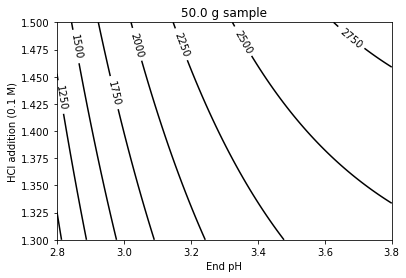

In [2]:
pH = np.linspace(2.8, 3.8, 100)
m_acid = np.linspace(1.3, 1.5, 100)

mpH, macid = np.meshgrid(pH, m_acid)

m_sample = 50
sal = 35
temp = 25
C_acid = 0.1

TA = 1e6 * TA_from_pH(mpH, m_sample, macid, sal, temp, C_acid)

cs = plt.contour(mpH, macid, TA, colors='k')
plt.clabel(cs, fmt='%.0f')

plt.xlabel('End pH')
plt.ylabel(f'HCl addition ({C_acid:.1f} M)')
plt.title(f'{m_sample:.1f} g sample')

This plot shows the relationship between moles of acid added ($m C$), sample mass ($m0$), the end-pH of the titration and sample TA. Three must be known to constrain the 4th - in our case $m C$, $m0$ and pH.

<a id="2_TAun"></a>
## 2. Minimising uncertainties in TA measurements

Given:

$$\frac{m C - m_0 TA}{m + m_0} = [H^+]_F + [HSO_4^-] + [HF] = \left( \frac{[H^+]_T}{1 + \frac{S_T}{K_{S}}} + \frac{S_T}{1 + K_{S} (1 + \frac{S_T}{K_{S}})[H^+]_T} + \frac{F_T}{1 + \frac{K_F}{[H^+]_T}}\right)$$

if $[HSO_4^-]$ and $[HF]$ are relatively constant, the key variables in a TA analysis are:

- $m_0 TA$ : moles of alkalinity in sample
- $m C$ : moles of acid added to sample
- $[H^+]_T = pH_{T}$ : End-pH of reaction.

The key variables under the control of the operator are:

- $m_0$ : mass of sample
- $m$ : mass of acid
- $C$ : concentration of acid

Although the concentration of the acid is generally fixed for an entire analytical session, and is not easily tuned.

The operater may readily modify $m_0$ and $m$ to obtain a different end-pH. The questions then are:

1. What is the optimal range for the reaction end-pH?
2. How do uncertainties in $m_0$, $m$ and $pH$ propagate to calculated $TA$?

<a id="2A_TAunc"></a>
### 2A. Sources of Uncertainty in a pH Measurement
$$
[H^+]_T = \left( \frac{m C -m_0\ TA}{m + m_0} - [HSO_4^-] - [HF]\right) \left( 1 + \frac{S_T}{K_S} \right)
$$

The propagation of uncertainty in each variable to a TA measurement can be calculated from the partial derivatives of Equation 1:

$$
\begin{align}
\frac{\delta TA}{\delta m} &= \frac{C}{m_{0}} - \frac{\frac{F_{T}}{\frac{K_{F}}{[H^{+}]_T} + 1} + \frac{S_{T}}{K_{S} [H^{+}]_T \left(1 + \frac{S_{T}}{K_{S}}\right) + 1} + \frac{[H^{+}]_T}{1 + \frac{S_{T}}{K_{S}}}}{m_{0}}  \\
\frac{\delta TA}{\delta m_0} &= - \frac{C m}{m_{0}^{2}} - \frac{\frac{F_{T}}{\frac{K_{F}}{[H^{+}]_T} + 1} + \frac{S_{T}}{K_{S} [H^{+}]_T \left(1 + \frac{S_{T}}{K_{S}}\right) + 1} + \frac{[H^{+}]_T}{1 + \frac{S_{T}}{K_{S}}}}{m_{0}} + \frac{\left(m + m_{0}\right) \left(\frac{F_{T}}{\frac{K_{F}}{[H^{+}]_T} + 1} + \frac{S_{T}}{K_{S} [H^{+}]_T \left(1 + \frac{S_{T}}{K_{S}}\right) + 1} + \frac{[H^{+}]_T}{1 + \frac{S_{T}}{K_{S}}}\right)}{m_{0}^{2}} \\
\frac{\delta TA}{\delta [H^+]_T} &= - \frac{\left(m + m_{0}\right) \left(\frac{F_{T} K_{F}}{\left([H^{+}]_T\right)^{2} \left(\frac{K_{F}}{[H^{+}]_T} + 1\right)^{2}} - \frac{K_{S} S_{T} \left(1 + \frac{S_{T}}{K_{S}}\right)}{\left(K_{S} [H^{+}]_T \left(1 + \frac{S_{T}}{K_{S}}\right) + 1\right)^{2}} + \frac{1}{1 + \frac{S_{T}}{K_{S}}}\right)}{m_{0}} \\
\frac{\delta TA}{\delta pH_T} &= - \frac{\left(m + m_{0}\right) \left(- \frac{10^{pH} F_{T} K_{F} \log{\left(10 \right)}}{\left(10^{pH} K_{F} + 1\right)^{2}} + \frac{10^{- pH} K_{S} S_{T} \left(1 + \frac{S_{T}}{K_{S}}\right) \log{\left(10 \right)}}{\left(1 + 10^{- pH} K_{S} \left(1 + \frac{S_{T}}{K_{S}}\right)\right)^{2}} - \frac{10^{- pH} \log{\left(10 \right)}}{1 + \frac{S_{T}}{K_{S}}}\right)}{m_{0}} \\
\frac{\delta TA}{\delta C} &= \frac{m}{m_{0}}
\end{align}
$$

In [3]:
def uncertainty_sources_pH(pH, m, m0, C, sal, temp):
    TA = TA_from_pH(pH, m0, m, sal, temp, C)
    H = 10**-pH
        
    dm0 = unTA.dTA_dm0(m0, H, m, C, temp, sal)
    dm = unTA.dTA_dm(C, m0, H, temp, sal)
    dC = unTA.dTA_dC(m, m0)
    dpH = unTA.dTA_dpH(pH, m, m0, sal, temp)
    
    uncertainties = {
        'm': dm * 1e6 * 1e-3,  # umol per mg
        'm0': dm0 * 1e6 * 1e-3,  # umol per mg
        'C': dC * 1e6 * 1e-5,  # umol per mM
        'pH': dpH * 1e6 * 1e-2, # umol per 0.01 pH
                    }
    units = {
        'm': '$mg^{-1}$',
        'C': '$0.1\ mM^{-1}$',
        'm0': '$mg^{-1}$',
        'pH': '$0.01\ pH^{-1}$'
             }
    
    return uncertainties, units

def plot_uncertainty_sources_pH(pH, m_acid, m_sample, C_acid, sal=35, temp=25):
    uncs, units = uncertainty_sources_pH(pH, m_acid, m_sample, C_acid, sal, temp)
    TA = TA_from_pH(pH, m_sample, m_acid, sal, temp, C_acid)
    
    fig, ax = plt.subplots(1, 1)

    x = 0
    labels = []
    for k, u in uncs.items():
        u = abs(u)
        ax.bar(x, u)

        va='bottom'
        if u < 0:
            va = 'top'
        ax.text(x, u, f'{u:.2f}', va=va, ha='center')
        labels.append(k + '\n' + units[k])
        x += 1

    ax.axhline(0, color=(0,0,0,0.6), zorder=-5)    
    ax.set_xticks(range(x))
    ax.set_xticklabels(labels)

    ylim = ax.get_ylim()
    yr = np.diff(ylim)
    ax.set_ylim(0, ylim[1] + 0.05 * yr)

    ax.set_ylabel('TA uncertainty $(\mu mol\ kg^{-1})$')
    
    label = 'Sample TA: {:.0f}\nSample (g): {:.0f}\nAcid (g): {:.1f}\nAcid (M): {:.2f}\nend-pH: {:.1f}'.format(TA * 1e6, m_sample, m_acid, C_acid, pH)
    
    ax.text(.01, .99, label, ha='left', va='top', transform=ax.transAxes)
    
    return fig, ax
    

<a id="fig4"></a>

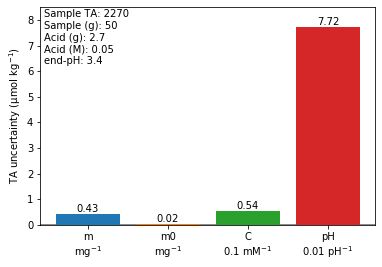

In [4]:
fig, ax = plot_uncertainty_sources_pH(3.4, 2.7, 50, 0.05, sal, temp)

fig.savefig(figpath + '4_TA_uncertainty.pdf')

**Figure 4:** The change in calculated TA as a function of each parameter in Eqn. 1. The magnitude of change in each parameter shown is representative of their readily achievable measurement precisions under field conditions. The TA measurement is most sensitive to changes in sample pH, which is the largest potential source of uncertainty in the TA measurement.

<a id="2B_endpH"></a>
### 2B. Optimal end-pH for TA Measurement

pH-error as a function of end-pH

Text(0, 0.5, 'dTA / 0.01 pH')

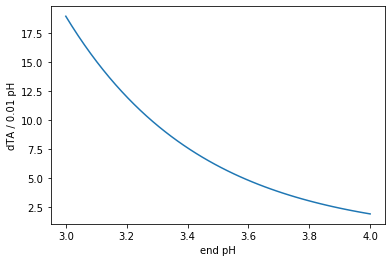

In [5]:
end_pH = np.linspace(3, 4)

TA_err = unTA.dTA_dpH(end_pH, 2, 50, 35, 25) * 1e6 * 1e-2

plt.plot(end_pH, TA_err)
plt.xlabel('end pH')
plt.ylabel('dTA / 0.01 pH')

<a id="fig5"></a>
The uncertainty in a TA measurement will depend both on the error relationship identified above, and the uncertainty in the pH measurement identified in the 'pH_fitting' supplement.

In [6]:
# load pH uncertainties as a function of end-pH and noise
pH_pred = np.load('./data/pH_pred.npy', allow_pickle=True)

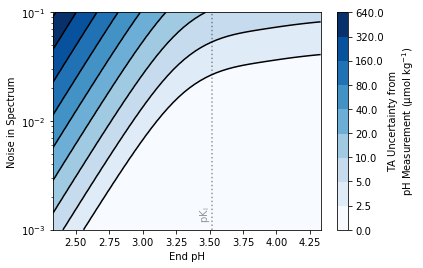

In [7]:
dTA_pred = unTA.dTA_dpH(pH_pred, 2.7, 50, 35, 25)  # calculate TA gradient
TA_err = unp.nominal_values(dTA_pred) * 1e6 * unp.std_devs(pH_pred)

# Uncertainties as a function of noise and end-pH
ipHs = np.linspace(2.33, 4.33, 50)
inoise_stds = np.logspace(-3, -1, 50)
pHs, noise_stds = np.meshgrid(ipHs, inoise_stds)

levels = [0, 2.5, 5, 10, 20, 40, 80, 160, 320, 640]
plt.contourf(pHs, noise_stds, TA_err, levels, cmap=plt.cm.Blues, norm=colors.BoundaryNorm(levels, 256))
plt.colorbar(label='TA Uncertainty from\npH Measurement ($\mu mol\ kg^{-1}$)')
plt.contour(pHs, noise_stds, TA_err, levels, colors=['k'])

plt.yscale('log')
plt.xlabel('End pH')
plt.ylabel('Noise in Spectrum')

pKdye = -np.log10(dye.K_handler('BPB', 25, 35))
plt.axvline(pKdye, ls='dotted', c=(0,0,0,0.4))
plt.text(pKdye, 9.5**-3, '$pK_{I}$', rotation=90, ha='right', va='bottom', color=(0,0,0,0.4))

plt.savefig(figpath + '5_TA_opt_pH.pdf')

**Figure 5:** The uncertainty in a calculated TA value propagated from uncertainty in the pH measurement. These patterns reflect the combination of the uncertainty in a pH measurement (Fig. 3C) with $\frac{\delta TA}{\delta pH}$ (Appendix 2). As with Fig. 3, noise in the spectrum should be below $10^{-2}$ under normal operating conditions. Calculations are for a spectrum containing 1200 data points, with $m_0=50$, $m=2.7$, $T=25$ and $S=35$.

From this, we see that the propagation of pH measurement uncertainty to a TA calculation result in maximum uncertainties at lower end pH values.
However at relatively low noise levels, as should be the case for most spectra, precise TA measurements should be obtainable from any pH value in reasonable proximity to the pK of the indicator.

<a id="3_bubbles"></a>
## 3. Is Bubbling Necessary?

The experimental protocol calls for bubbling the sample with air to drive off excess CO2. Is this necessary?

In [8]:
# TA at end-point
TA_endpoint = cb.Csys(pHtot=3.4, pCO2=400).TA
TA_endpoint

array([-405.7253978])

In [9]:
# What's the max pCO2 after acid addition
pCO2_endpoint = cb.Csys(pHtot=3.4, DIC=2100).pCO2
pCO2_endpoint

73937.4076122309

In [10]:
# Difference in end-point pH if unpurged 
dpH = 3.4 - cb.Csys(TA=TA_endpoint, pCO2=pCO2_endpoint).pHtot
dpH 

array([0.0077672])

In [11]:
# which, under normal operating conditions, translates to an alkalinity error of:
unTA.dTA_dpH(3.4, 1.4, 50, 35, 25) * 1e6 * dpH

array([5.84488997])

Can produce a ~5.8 umol/kg TA error under normal operating conditions - bubbling *is* necessary.